In [1]:
import tensorflow as tf
from tensorflow import keras 

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os 

### Label Encoding for Flower Names

In [2]:
def class_to_int(flower):
    if flower == 'setosa':
        return 0
    if flower == 'versicolor':
        return 1
    else:
        return 2

### Data Ingestion and Preprocessing

In [3]:
def read_data():
    
    # Reading from input file into a Pandas Dataframe.
    df = pd.read_csv('iris.csv')
    
    # Label Encoding the target variable, i.e. Species.
    label_encoder = preprocessing.LabelEncoder()
    df['Species'] = label_encoder.fit_transform(df['Species'])

    # Converting the input Dataframe to a NumPy array.
    np_df = df.to_numpy()

    # Storing feature (independent) variables of all rows into X_data.
    X = np_df[:, 0:4]
    # Storing target (dependent) variable of all rows into Y_data.
    Y = np_df[:, 4]
    
    # Define a scaler model that fits on the input data
    scaler = StandardScaler().fit(X)

    # Scaling the numeric feature variables.
    X = scaler.transform(X)

    # Converting the target variable to a one-hot-encoding array.
    Y = tf.keras.utils.to_categorical(Y, 3)
    
    return X, Y

### Default Model Configuration

In [4]:
def default_model_configuration():
    model_config = {
        "HIDDEN_NODES": [32, 64],
        "HIDDEN_ACTIVATION": "relu",
        "OUTPUT_NODES": 3,
        "OUTPUT_ACTIVATION": "softmax",
        "WEIGHTS_INITIALIZER": "random_normal",
        "BIAS_INITIALIZER": "zeros",
        "NORMALIZATION": "none",
        "OPTIMIZER": "rmsprop",
        "LEARNING_RATE": 0.001,
        "REGULARIZER": None,
        "DROPOUT_RATE": 0.0,
        "EPOCHS": 10,
        "BATCH_SIZE": 16,
        "VALIDATION_SPLIT": 0.2,
        "VERBOSE": 0,
        "LOSS_FUNCTION": "categorical_crossentropy",
        "METRICS": ["accuracy"]
    }
    return model_config

### Apply Learning Rate to the Corresponding Optimizer

In [5]:
def adjust_optimizer(optimizer, lr):
    
    # Initialization:
    adjusted_optimizer = None
    
    if optimizer == 'adam':
        adjusted_optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif 'adagrad':
        adjusted_optimizer = keras.optimizers.Adagrad(learning_rate=lr)
    elif 'rmsprop':
        adjusted_optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        adjusted_optimizer = keras.optimizers.SDG(learning_rate=lr)
    
    return adjusted_optimizer

### Build and Fit the Model

In [6]:
def model_build_fit(model_config, X, Y, model_name):
    
    # Building the model.
    model = tf.keras.models.Sequential(name=model_name)
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if(layer == 0):
            model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                                   input_shape=(X.shape[1],),
                                   name="Input_Layer",
                                   kernel_initializer=model_config["WEIGHTS_INITIALIZER"],
                                   bias_initializer=model_config["BIAS_INITIALIZER"],
                                   kernel_regularizer=model_config["REGULARIZER"],
                                   activation=model_config["HIDDEN_ACTIVATION"])
            )
        else:
            if(model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if(model_config["DROPOUT_RATE"] > 0.0):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
            
            model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                                   name="HIDDEN_LAYER_" + str(layer),
                                   kernel_initializer=model_config["WEIGHTS_INITIALIZER"],
                                   bias_initializer=model_config["BIAS_INITIALIZER"],
                                   kernel_regularizer=model_config["REGULARIZER"],
                                   activation=model_config["HIDDEN_ACTIVATION"])
            )
            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                                 name="OUTPUT_LAYER",
                                 activation=model_config["OUTPUT_ACTIVATION"]))
        
    optimizer = adjust_optimizer(model_config["OPTIMIZER"], model_config["LEARNING_RATE"])
    
    # Compiling the model.    
    model.compile(loss=model_config["LOSS_FUNCTION"], optimizer=optimizer,
                  metrics=model_config["METRICS"])
    
    # Splitting X and Y data to train and validation datasets.
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify=Y, 
                                                      test_size=model_config["VALIDATION_SPLIT"])
    
    # Training the model.
    history = model.fit(X_train, Y_train,
                        batch_size=model_config["BATCH_SIZE"],
                        epochs=model_config["EPOCHS"],
                        verbose=model_config["VERBOSE"],
                        validation_data=(X_val, Y_val))
    
    return history
    
        
        

### Plot a Chart of the Accuracy of the Model Over Epochs

In [7]:
def plot_chart(accuracies, title):
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 8))
    for experiment in accuracies.keys():
        plt.plot(accuracies[experiment],
                 label=experiment,
                 linewidth=3)
        
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Find the Best Epoch and Batch Sizes

2023-09-12 14:53:49.606476: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


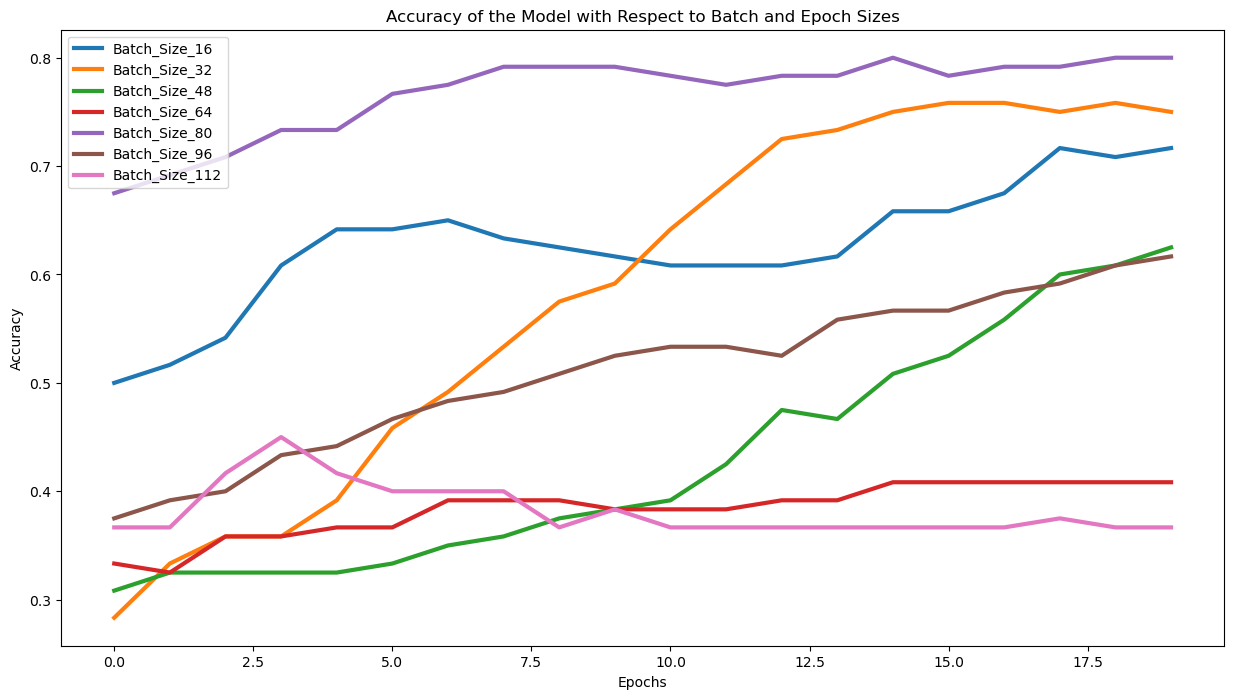

In [8]:
# The experimental values for Batch and Epochs are overriding the default values specified
# in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

for batch_size in range(16, 128, 16):
    
    # Load the default model configuration.
    model_config = default_model_configuration()
    
    # Load input data and perform preprocessing.
    X, Y = read_data()
    
    # Initialize Epoch with 20 iterations.
    model_config["EPOCHS"] = 20
    
    model_config["BATCH_SIZE"] = batch_size
    
    model_name = "Batch_Size_" + str(batch_size)
    
    history = model_build_fit(model_config, X, Y, model_name)
    
    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]
    
plot_chart(accuracies, "Accuracy of the Model with Respect to Batch and Epoch Sizes")

### Find the Best Number of Hidden Layers

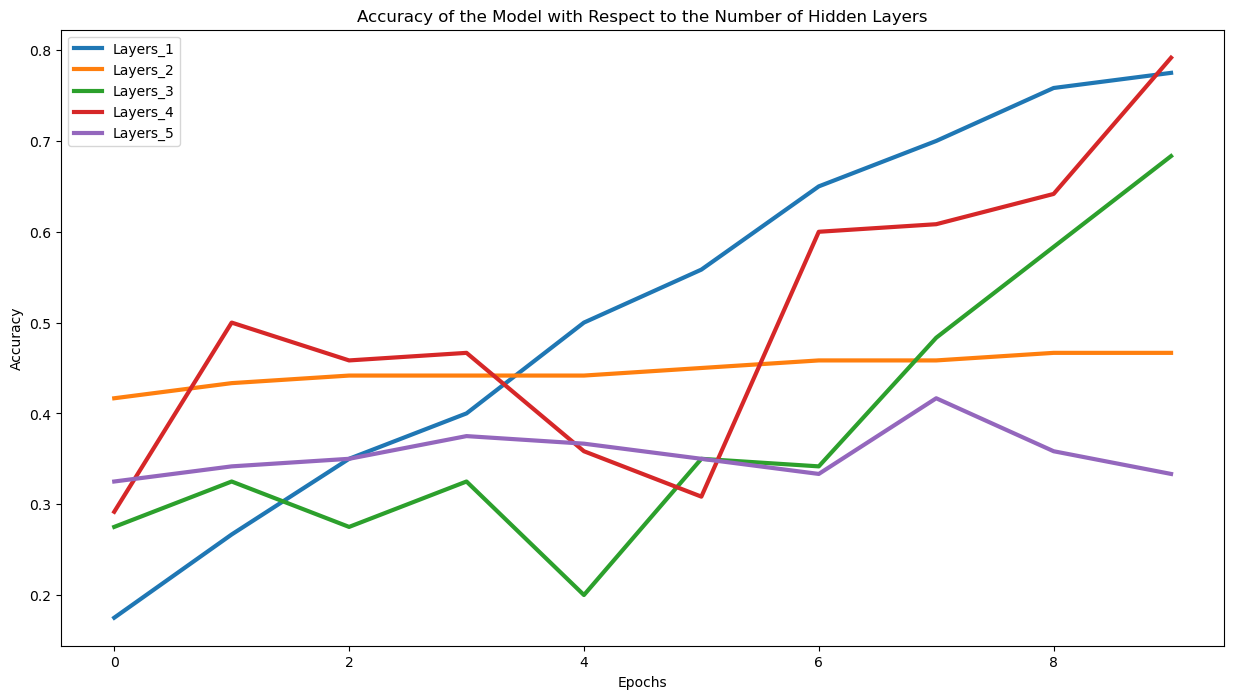

In [9]:
# The experimental values for hidden layers are overriding the default values specified
# in the default_model_configuration() function.
# For each hidden layer, 32 nodes are specified.

# Initialize a dict for the accuracy measures.
accuracies = {}

# Initialize a list for the number of nodes in each hidden layer.
layers_nodes = []

for layer in range(1, 6):
    
    # Assign 32 nodes to this layer.
    layers_nodes.append(32)
    
    model_config = default_model_configuration()
    X, Y = read_data()
    
    model_config["HIDDEN_NODES"] = layers_nodes
    model_name = "Layers_" + str(layer)
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Number of Hidden Layers")

So the best number for hidden layers is 2.

### Find the Best Number for Nodes in a Layer

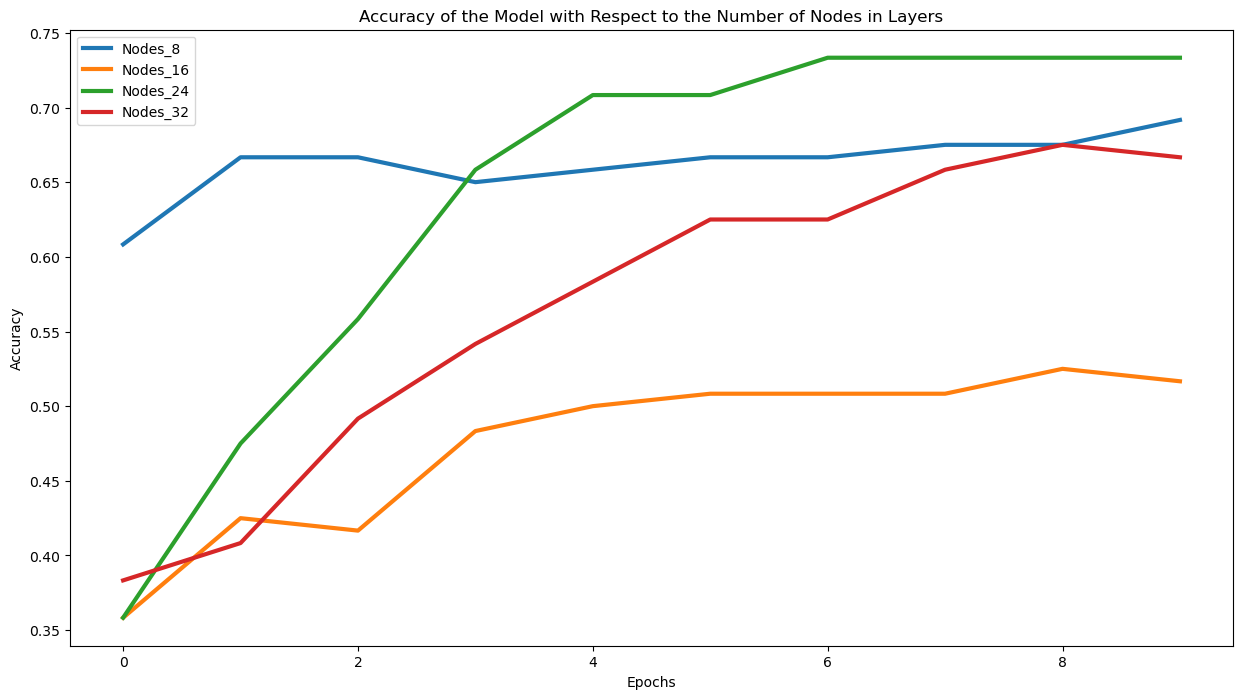

In [10]:
# The experimental values for number of nodes are overriding the default values specified
# in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

for node in range(8, 40, 8):
    
    layers_nodes = []
    
    # We just found out that 2 is the optimal value for number of hidden layers.
    for layer in range(2):
        layers_nodes.append(node)
    
    model_config = default_model_configuration()
    X, Y = read_data()
    
    model_config["HIDDEN_NODES"] = layers_nodes
    model_name = "Nodes_" + str(node)
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Number of Nodes in Layers")

### Find the Best Activation Function

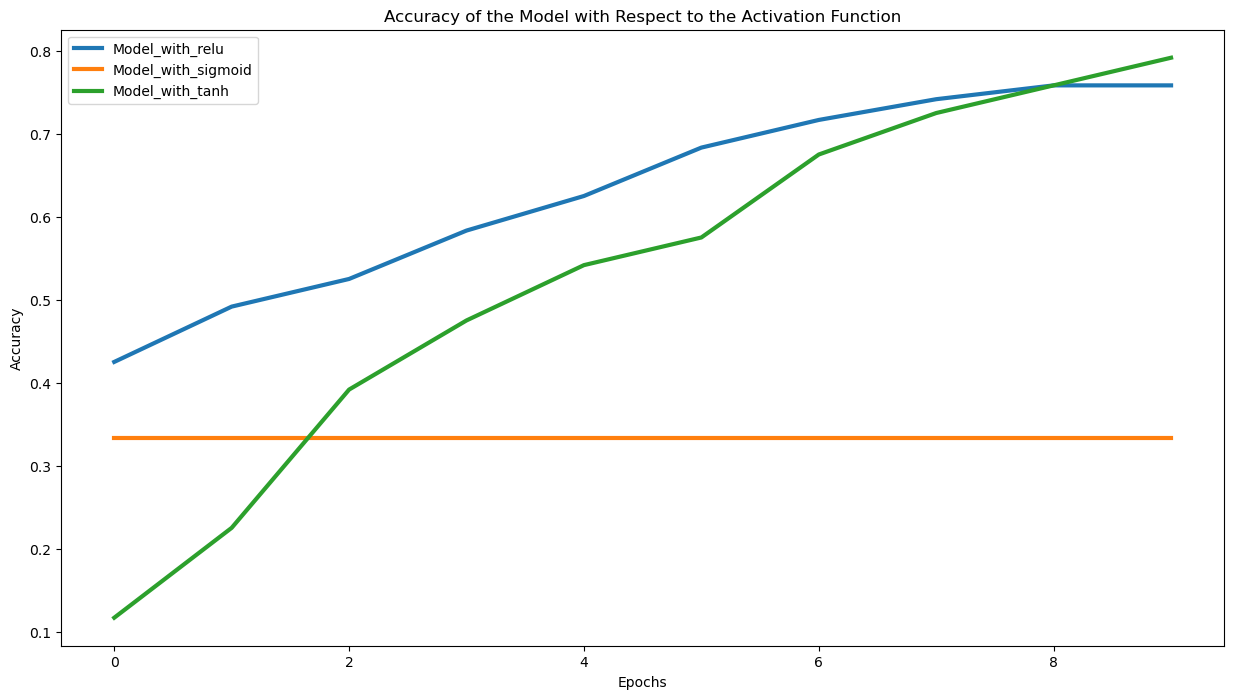

In [11]:
# The experimental values for activation functions are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

activation_functions = ['relu', 'sigmoid', 'tanh']

for activation in activation_functions:
    
    model_config = default_model_configuration()
    X, Y = read_data()
    
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model_with_" + activation
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Activation Function")

### Find the Best Weights Initialization

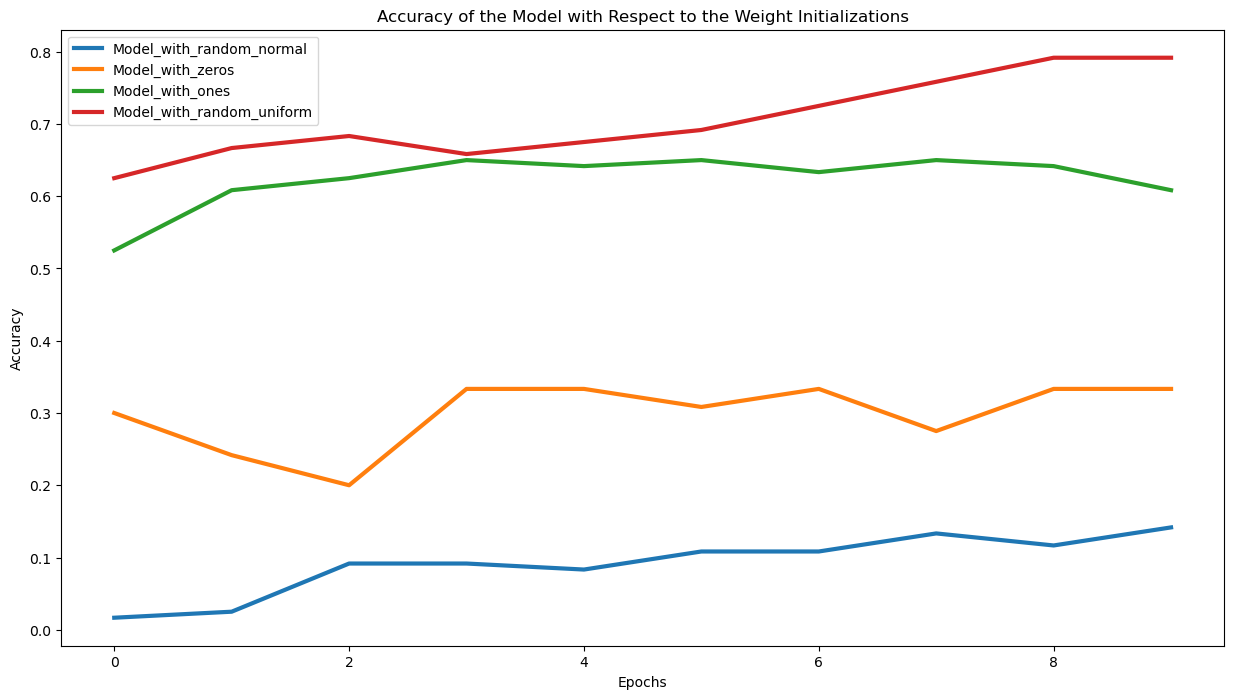

In [12]:
# The experimental values for weight initializations are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

initializations = ["random_normal", "zeros", "ones", "random_uniform"]

for init in initializations:
    
    model_config = default_model_configuration()
    X, Y = read_data()
    
    model_config["WEIGHTS_INITIALIZER"] = init 
    model_name = "Model_with_" + init 
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Weight Initializations")

### Find Whether or not Batch Normalization Improves Accuracy in this Case

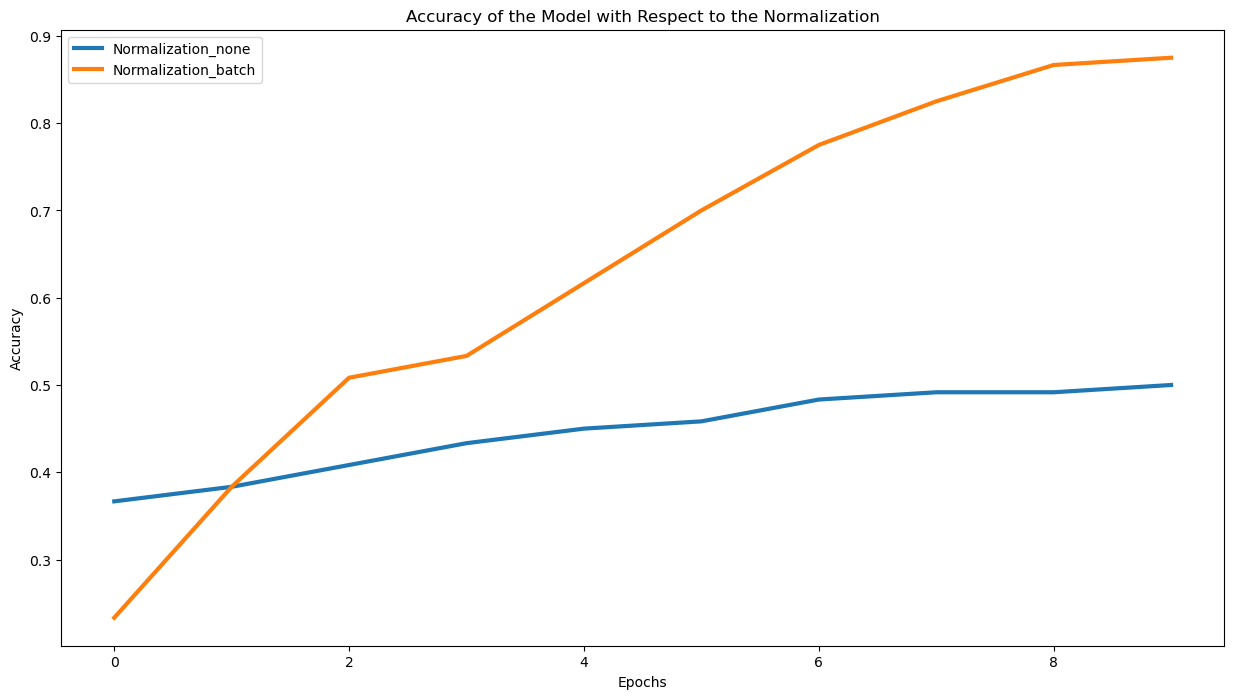

In [13]:
# The experimental values for batch normalizations are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

normalizations = ['none', 'batch']

for norm in normalizations:
    model_config = default_model_configuration()
    X, Y = read_data()
    
    model_config["NORMALIZATION"] = norm 
    model_name = 'Normalization_' + norm 
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Normalization") 

### Find the Best Optimizer

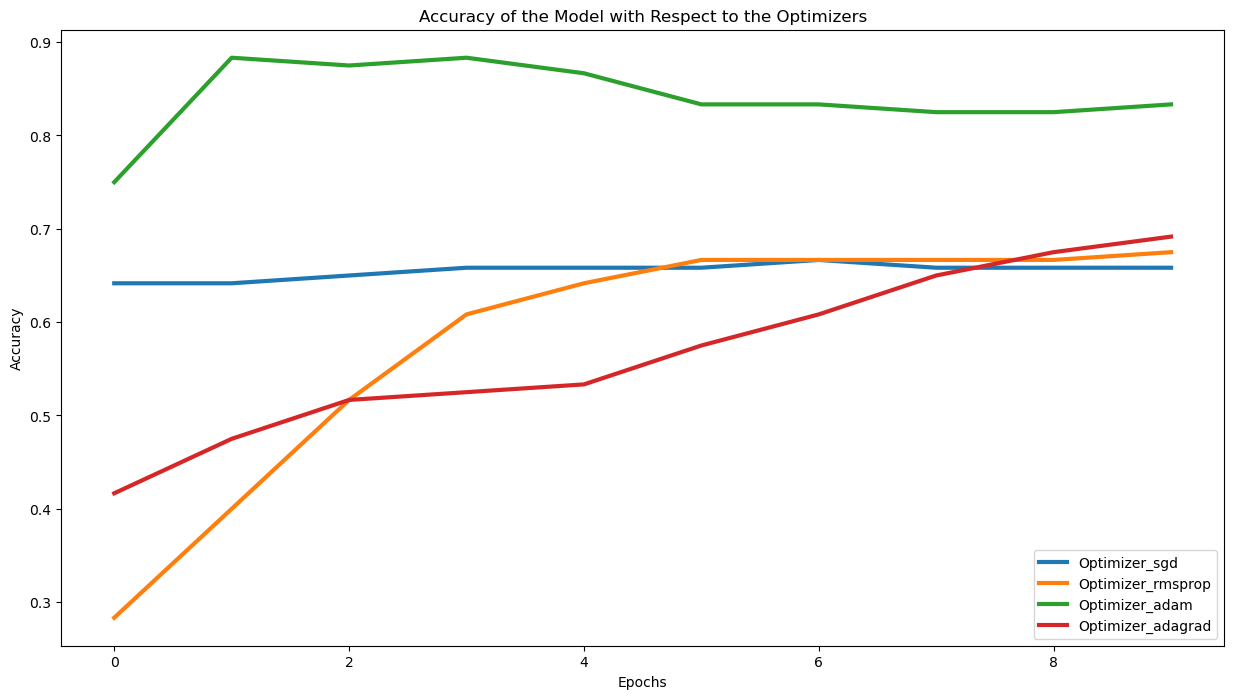

In [14]:
# The experimental values for the optimizers are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

optimizers = ['sgd', 'rmsprop', 'adam', 'adagrad']

for opt in optimizers:
    model_config = default_model_configuration()
    X, Y = read_data()

    model_config["OPTIMIZER"] = opt
    model_name = 'Optimizer_' + opt
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Optimizers") 

### Find the Best Value for Learning Rate

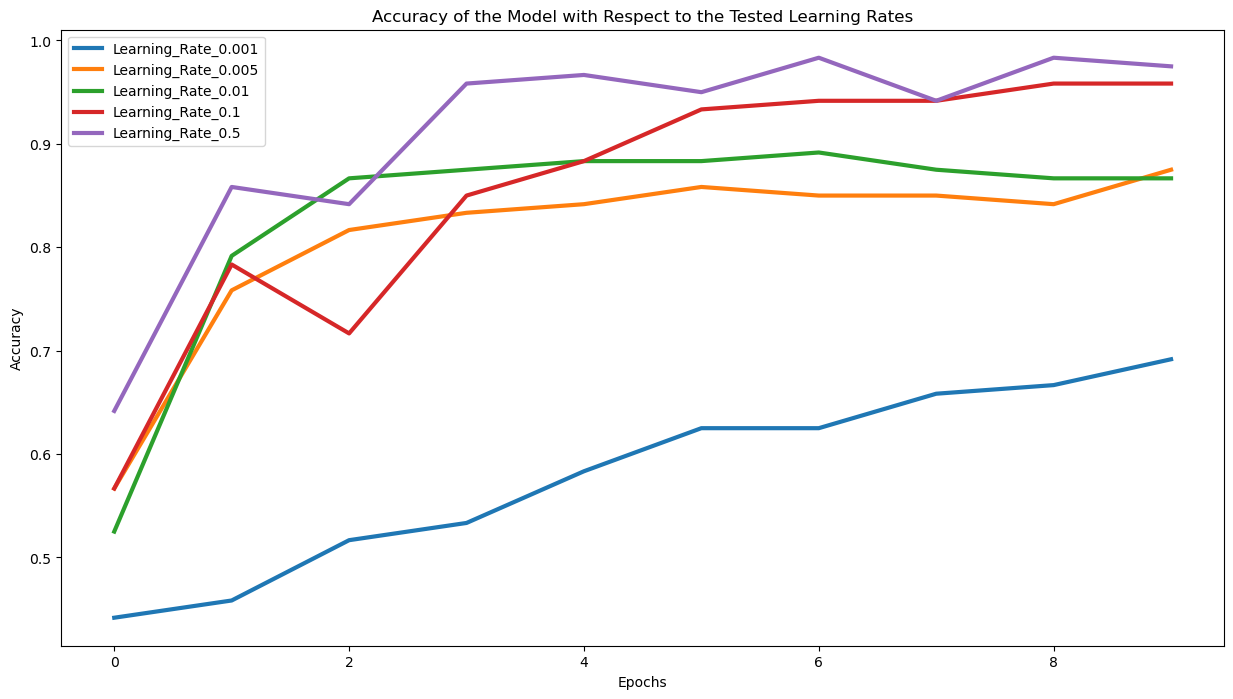

In [16]:
# The experimental values for learning rates are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

learning_rates = [0.001, 0.005, 0.01, 0.1, 0.5]

for lr in learning_rates:
    model_config = default_model_configuration()
    X, Y = read_data()

    model_config["LEARNING_RATE"] = lr
    model_name = 'Learning_Rate_' + str(lr)
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the accuracy of this model.
    accuracies[model_name] = history.history["accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Tested Learning Rates") 

### Find the Best Regularization Algorithm

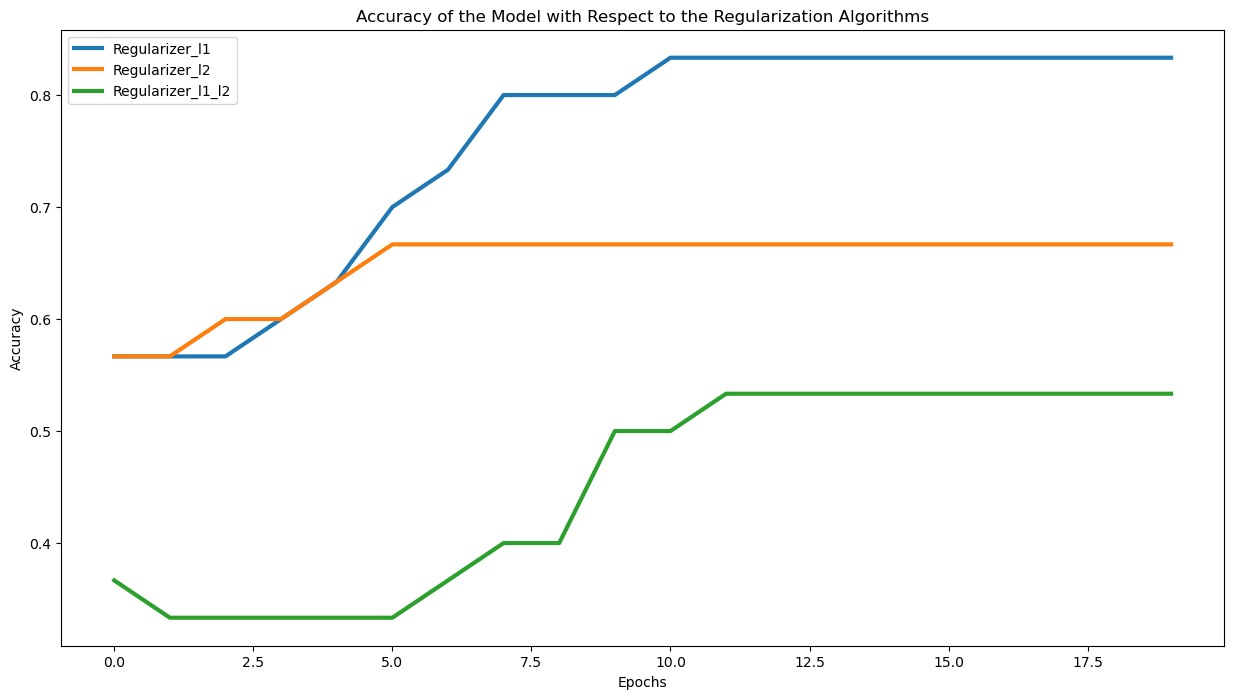

In [23]:
# The experimental values for the regularizers are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

regularizers = ['l1', 'l2', 'l1_l2']

for reg in regularizers:
    model_config = default_model_configuration()
    X, Y = read_data()

    model_config["REGULARIZER"] = reg
    model_name = 'Regularizer_' + reg

    # Increasing the Epochs to run a more accurate comparison.
    model_config["EPOCHS"] = 20
    
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the validation accuracy of this model. For overfitting experiments we are comparing
    # validation accuracy, and not [training] accuracy.
    accuracies[model_name] = history.history["val_accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Regularization Algorithms") 

### Find the Best Value for Dropout

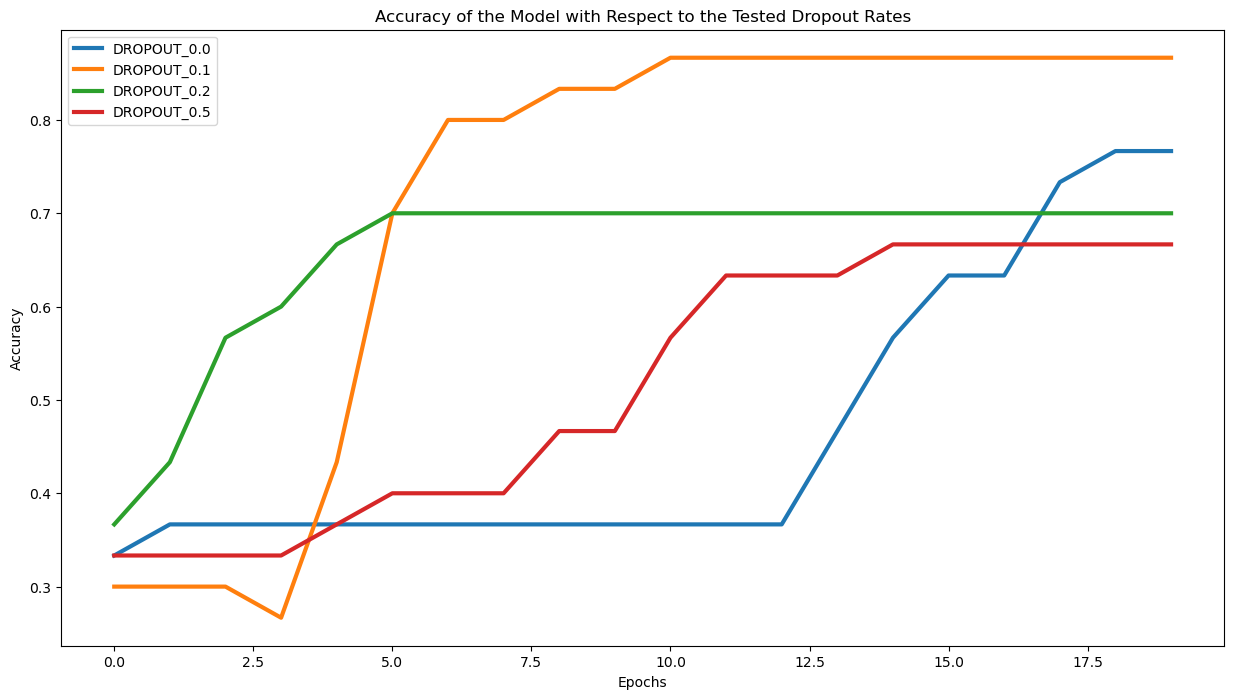

In [27]:
# The experimental values for the dropout are overriding the default values
# specified in the default_model_configuration() function.

# Initialize a dict for the accuracy measures.
accuracies = {}

dropout_rates = [0.0, 0.1, 0.2, 0.5]

for dropout in dropout_rates:
    model_config = default_model_configuration()
    X, Y = read_data()

    model_config["DROPOUT_RATE"] = dropout
    model_name = 'DROPOUT_' + str(dropout)
    
    # Increasing the Epochs to run a more accurate comparison.
    model_config["EPOCHS"] = 20
    
    history = model_build_fit(model_config, X, Y, model_name)

    # Save the validation accuracy of this model. For overfitting experiments we are comparing
    # validation accuracy, and not [training] accuracy.
    accuracies[model_name] = history.history["val_accuracy"]

plot_chart(accuracies, "Accuracy of the Model with Respect to the Tested Dropout Rates") 